In [1]:

import pandas as pd

%matplotlib inline

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
%%time
from ams.config import constants
from pathlib import Path
from ams.services import file_services

senti_dataframes = []

folder_path_str = Path(constants.TWITTER_OUTPUT_RAW_PATH, "sent_drop", "main")

file_paths = file_services.list_files(folder_path_str, ends_with=".parquet", use_dir_recursion=True)

Setting up logging...
Will use logging path: C:\Users\Chris\workspaces\data\logs\alpha_media_signal
Wall time: 70 ms


In [3]:
from ams.utils.date_utils import TZ_AMERICA_NEW_YORK, STANDARD_DAY_FORMAT
import pytz

def convert_to_date_string(utc_timestamp: int):
    dt_utc = datetime.fromtimestamp(utc_timestamp)
    dt_nyc = dt_utc.astimezone(pytz.timezone(TZ_AMERICA_NEW_YORK))
    return dt_nyc.strftime(STANDARD_DAY_FORMAT)

In [4]:
%%time

from ams.utils import date_utils
from datetime import datetime

twitter_format = date_utils.TWITTER_LONG_FORMAT 
    
def add_ts(date_string: str):
        result = None
        try:
            dt = datetime.strptime(date_string, twitter_format)
            result = int(dt.timestamp())
        except Exception as e:
            pass
        return result

def add_timestamp(df):
    print(f'Count: {df.shape[0]}')
        
    df = df[df['created_at'].notnull()]
    
    df["created_at_timestamp"] = df["created_at"].apply(add_ts)
    
    return df

Wall time: 0 ns


In [5]:

def get_fave_cols(df):
    return df[["created_at",
                     "user_screen_name",
                     "favorite_count",
                     "in_reply_to_screen_name",
                     "user_verified",
                     "metadata_result_type",
                     "user_listed_count",
                     "user_time_zone",
                     "user_has_extended_profile",
                     "in_reply_to_status_id",
                     "user_statuses_count",
                     "user_protected",
                     "user_is_translation_enabled",
                     "user_location",
                     "lang",
                     "user_geo_enabled",
                     "place_country",
                     "place_name",
                     "possibly_sensitive",
                     "user_friends_count",
                     "retweet_count",
                     "user_follow_request_sent",
                     "user_followers_count",
                     "f22_ticker",
                     "f22_has_cashtag",
                     "f22_ticker_in_text",
                     "f22_num_other_tickers_in_tweet",
                     "f22_sentiment_pos",
                     "f22_sentiment_neu",
                     "f22_sentiment_neg",
                     "f22_sentiment_compound",
                     "f22_id"]]

In [6]:
from ams.services import  file_services
from pyspark.sql import DataFrame

tag = 'lpd'
parent_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, 'learning_prep_drop', "main")
sent_drop_path = file_services.create_unique_folder_name(parent_path, prefix=tag)

print(f"Drop path: '{sent_drop_path}'.")

def persist_parquet(df: DataFrame):
    file_path =  file_services.create_unique_filename(parent_dir=sent_drop_path, prefix="lpd", extension="parquet")
    file_path_str = str(file_path)
    df.to_parquet(file_path_str)

Drop path: 'C:\Users\Chris\workspaces\data\twitter\learning_prep_drop\main\lpd_2020-12-28_13-31-35-672.51'.


In [7]:
%%time

def calc_compound_score(row):
    return row["user_followers_count"] * row["f22_sentiment_compound"]

samples = []
tot_files = len(file_paths)
for f_ndx, f in enumerate(file_paths):
    print(f"Processing {f_ndx + 1} of {tot_files}: {f}")
    df = pd.read_parquet(f)
    
    print(f"\t{df.shape}")
    
    df = get_fave_cols(df)
    
    df = add_timestamp(df)
       
    df = df[df['created_at_timestamp'].notnull()]
    
    df['date'] = df['created_at_timestamp'].apply(convert_to_date_string)
    
    df = df[df['user_followers_count'].notnull()]
    df = df[df['f22_sentiment_compound'].notnull()]
    
    df['user_followers_count'] = df['user_followers_count'].astype("int")
    df['f22_sentiment_compound'] = df['f22_sentiment_compound'].astype("float64")            
            
    df['f22_compound_score'] = df.apply(calc_compound_score, axis=1)
    
    df = df.drop_duplicates(subset=['f22_id'])
    
    persist_parquet(df=df)
    samples.append(df.sample(frac=.001))


Processing 1 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.0.parquet
	(7078, 79)
Count: 7078
Processing 2 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.1.parquet
	(7078, 79)
Count: 7078
Processing 3 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.10.parquet
	(7078, 79)
Count: 7078
Processing 4 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.11.parquet
	(7078, 79)
Count: 7078
Processing 5 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.12.parquet
	(7078, 79)
Count: 7078
Processing 6 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.13.parquet
	(7078, 79)
Count: 7078
Processing 7 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_11-58-43-240.24\part.14.parquet
	(7078, 79)

Processing 58 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.11.parquet
	(7078, 79)
Count: 7078
Processing 59 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.12.parquet
	(7078, 79)
Count: 7078
Processing 60 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.13.parquet
	(7078, 79)
Count: 7078
Processing 61 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.14.parquet
	(7078, 79)
Count: 7078
Processing 62 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.15.parquet
	(7078, 79)
Count: 7078
Processing 63 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.16.parquet
	(7078, 79)
Count: 7078
Processing 64 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-00-46-591.5\part.17.parquet
	(7078, 7

Processing 115 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.14.parquet
	(7078, 79)
Count: 7078
Processing 116 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.15.parquet
	(7078, 79)
Count: 7078
Processing 117 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.16.parquet
	(7078, 79)
Count: 7078
Processing 118 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.17.parquet
	(7078, 79)
Count: 7078
Processing 119 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.18.parquet
	(7078, 79)
Count: 7078
Processing 120 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.19.parquet
	(7078, 79)
Count: 7078
Processing 121 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-02-50-268.77\part.2.parq

Processing 171 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.16.parquet
	(7071, 79)
Count: 7071
Processing 172 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.17.parquet
	(7071, 79)
Count: 7071
Processing 173 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.18.parquet
	(7071, 79)
Count: 7071
Processing 174 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.19.parquet
	(7071, 79)
Count: 7071
Processing 175 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.2.parquet
	(7071, 79)
Count: 7071
Processing 176 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.20.parquet
	(7071, 79)
Count: 7071
Processing 177 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-05-04-339.84\part.21.parq

Processing 227 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.18.parquet
	(7071, 79)
Count: 7071
Processing 228 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.19.parquet
	(7071, 79)
Count: 7071
Processing 229 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.2.parquet
	(7071, 79)
Count: 7071
Processing 230 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.20.parquet
	(7071, 79)
Count: 7071
Processing 231 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.21.parquet
	(7071, 79)
Count: 7071
Processing 232 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.22.parquet
	(7071, 79)
Count: 7071
Processing 233 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-07-06-894.9\part.23.parquet
	(7

Processing 283 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.2.parquet
	(7071, 79)
Count: 7071
Processing 284 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.20.parquet
	(7071, 79)
Count: 7071
Processing 285 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.21.parquet
	(7071, 79)
Count: 7071
Processing 286 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.22.parquet
	(7071, 79)
Count: 7071
Processing 287 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.23.parquet
	(7071, 79)
Count: 7071
Processing 288 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.24.parquet
	(7071, 79)
Count: 7071
Processing 289 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-09-10-238.55\part.25.parq

Processing 339 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.21.parquet
	(7079, 79)
Count: 7079
Processing 340 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.22.parquet
	(7079, 79)
Count: 7079
Processing 341 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.23.parquet
	(7079, 79)
Count: 7079
Processing 342 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.24.parquet
	(7079, 79)
Count: 7079
Processing 343 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.25.parquet
	(7079, 79)
Count: 7079
Processing 344 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.26.parquet
	(7073, 79)
Count: 7073
Processing 345 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-11-25-669.29\part.3.parq

Processing 396 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.24.parquet
	(7079, 79)
Count: 7079
Processing 397 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.25.parquet
	(7079, 79)
Count: 7079
Processing 398 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.26.parquet
	(7073, 79)
Count: 7073
Processing 399 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.3.parquet
	(7079, 79)
Count: 7079
Processing 400 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.4.parquet
	(7079, 79)
Count: 7079
Processing 401 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.5.parquet
	(7079, 79)
Count: 7079
Processing 402 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-13-29-195.3\part.6.parquet
	(7079

Processing 452 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.26.parquet
	(7072, 79)
Count: 7072
Processing 453 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.3.parquet
	(7079, 79)
Count: 7079
Processing 454 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.4.parquet
	(7079, 79)
Count: 7079
Processing 455 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.5.parquet
	(7079, 79)
Count: 7079
Processing 456 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.6.parquet
	(7079, 79)
Count: 7079
Processing 457 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.7.parquet
	(7079, 79)
Count: 7079
Processing 458 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-15-32-627.67\part.8.parquet
	

Processing 509 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-17-40-178.56\part.5.parquet
	(5998, 79)
Count: 5998
Processing 510 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-17-40-178.56\part.6.parquet
	(5998, 79)
Count: 5998
Processing 511 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-17-40-178.56\part.7.parquet
	(5998, 79)
Count: 5998
Processing 512 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-17-40-178.56\part.8.parquet
	(5998, 79)
Count: 5998
Processing 513 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-17-40-178.56\part.9.parquet
	(5998, 79)
Count: 5998
Processing 514 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-18-33-565.03\part.0.parquet
	(5998, 79)
Count: 5998
Processing 515 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-18-33-565.03\part.1.parquet
	(

Processing 565 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-19-26-321.87\part.7.parquet
	(5998, 79)
Count: 5998
Processing 566 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-19-26-321.87\part.8.parquet
	(5998, 79)
Count: 5998
Processing 567 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-19-26-321.87\part.9.parquet
	(5998, 79)
Count: 5998
Processing 568 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-20-19-678.29\part.0.parquet
	(5998, 79)
Count: 5998
Processing 569 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-20-19-678.29\part.1.parquet
	(5998, 79)
Count: 5998
Processing 570 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-20-19-678.29\part.10.parquet
	(5998, 79)
Count: 5998
Processing 571 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-20-19-678.29\part.11.parquet


Processing 621 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-21-13-670.22\part.9.parquet
	(5998, 79)
Count: 5998
Processing 622 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-22-07-546.4\part.0.parquet
	(5998, 79)
Count: 5998
Processing 623 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-22-07-546.4\part.1.parquet
	(5998, 79)
Count: 5998
Processing 624 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-22-07-546.4\part.10.parquet
	(5998, 79)
Count: 5998
Processing 625 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-22-07-546.4\part.11.parquet
	(5998, 79)
Count: 5998
Processing 626 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-22-07-546.4\part.12.parquet
	(5998, 79)
Count: 5998
Processing 627 of 648: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2020-12-28_12-22-07-546.4\part.13.parquet
	(59

Wall time: 770 ms


<AxesSubplot:xlabel='date'>

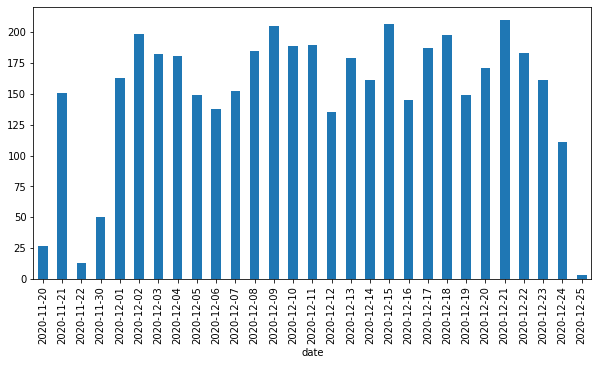

In [8]:
%%time 

df_combined = pd.concat(samples, axis=0)

df_combined.sort_values(by=['date'], inplace=True)

day_groups = df_combined.groupby(df_combined['date'])['date'].count()

day_groups.plot(kind='bar', figsize=(10,5), legend=None)